In [1]:
truth = [
    {"t0": 0.5, "D": 0.03, "P": 1.8, "depth": 2e-3},
    {"t0": 0.2, "D": 0.03, "P": 0.7, "depth": 1e-3},
]

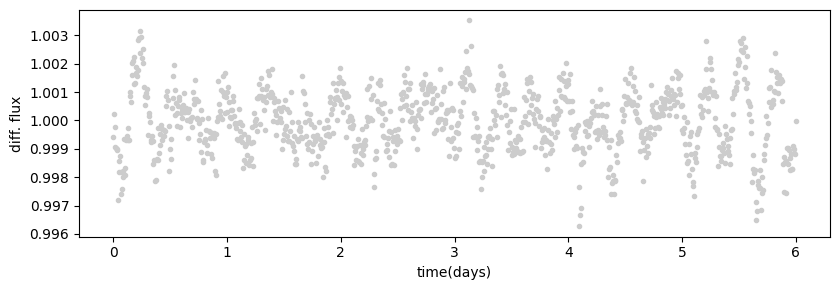

In [12]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
import numpy as np
import matplotlib.pyplot as plt
from nuance.utils import periodic_transit

# measurements
time = np.linspace(0, 6, 1000)
error = 0.0005

transits = [p["depth"] * periodic_transit(time, p["t0"], p["D"], p["P"]) for p in truth]
mean = np.sum(transits, 0) + 1.0

# GP
kernel = tinygp.kernels.quasisep.SHO(
    np.pi / (truth[1]["D"] * 5), 8.0, truth[1]["depth"]
)
gp = tinygp.GaussianProcess(kernel, time, diag=error**2, mean_value=mean)
flux = gp.sample(jax.random.PRNGKey(40))

plt.figure(None, (8.5, 3))
plt.plot(time, flux, ".", c="0.8")
plt.ylabel("diff. flux")
plt.xlabel("time(days)")

plt.tight_layout()
plt.savefig("example_0.png", dpi=300)

In [13]:
from nuance import Nuance, utils

nu = Nuance(time, flux, gp=tinygp.GaussianProcess(kernel, time, diag=error**2))

t0s = time.copy()
Ds = np.linspace(0.01, 0.2, 15)
nu.linear_search(t0s, Ds)


100%|██████████| 1000/1000 [00:00<00:00, 1783.63it/s]


In [14]:
periods = np.linspace(0.1, 5, 4000)
search = nu.periodic_search(periods)


100%|██████████| 4000/4000 [00:04<00:00, 916.67it/s] 


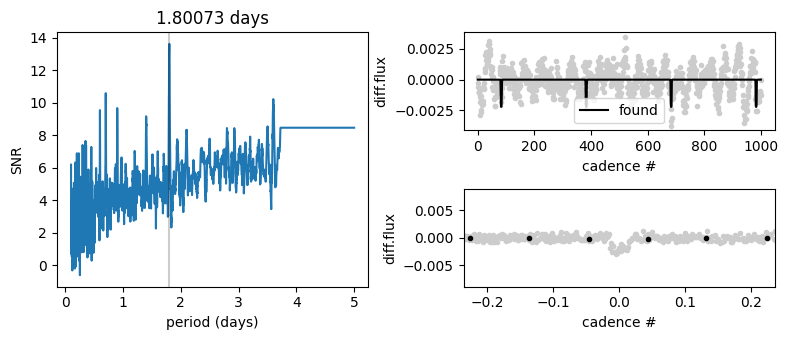

In [15]:
from nuance.utils import plot_search

plt.figure(None, (8, 3.5))
plot_search(nu, search)


ax1 = plt.gcf().axes[0]
ax1.axvline(truth[0]["P"], c="k", alpha=0.2, label="truth")
ax1.set_xlabel("period (days)")
ax1.set_ylabel("SNR")
ax2.legend()

ax2 = plt.gcf().axes[1]
ax2.set_xlabel("cadence #")
ax2.set_ylabel("diff.flux")

ax3 = plt.gcf().axes[2]
ax3.set_xlabel("cadence #")
ax3.set_ylabel("diff.flux")

plt.tight_layout()
plt.savefig("example.png", dpi=300)
